
# Example 2: Machine-learning benzene energies.
This example demonstrates:

1. How to read ellipsoidal frames from ``.xyz`` file.
2. How to convert ellipsoidal frames to AniSOAP vectors.
3. How to use these frames in machine learning models.


In [1]:
import metatensor
import numpy as np
from anisoap.representations import EllipsoidalDensityProjection
from anisoap.utils import ClebschGordanReal, cg_combine, standardize_keys
from ase.io import read
from matplotlib import pyplot as plt
from matplotlib import rc
from featomic import SoapPowerSpectrum
from sklearn.decomposition import PCA
from skmatter.metrics import global_reconstruction_error as GRE
from sklearn.model_selection import train_test_split
from skmatter.preprocessing import StandardFlexibleScaler
import pickle

/Users/alin62/miniconda3/envs/anisoap/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read the frames



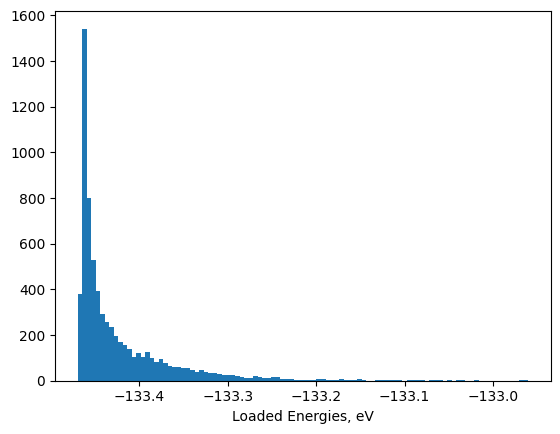

In [2]:
lmax = 9
nmax = 6

atom_frames = read("benzenes.xyz", ":")  # all atom frames, containing benzene energies
frames = read("ellipsoids.xyz", ":")  # ellipsoid frames
energies = np.array([aframe.info["energy_pa"] for aframe in atom_frames])
energies = np.reshape(
    energies, (-1, 1)
)  # Turn energies into column vector, required for sklearn
plt.hist(energies, bins=100)
plt.xlabel("Loaded Energies, eV")
plt.show()

Computing the AniSOAP Vectors

* The ideal semiaxes for the ellipsoid are (4, 4, 0.5)



In [3]:
a1, a2, a3 = 4.0, 4.0, 0.5
for frame in frames:
    frame.arrays["c_diameter[1]"] = a1 * np.ones(len(frame))
    frame.arrays["c_diameter[2]"] = a2 * np.ones(len(frame))
    frame.arrays["c_diameter[3]"] = a3 * np.ones(len(frame))

AniSOAP_HYPERS = {
    "max_angular": lmax,
    "max_radial": nmax,
    "radial_basis_name": "gto",
    "subtract_center_contribution": True,
    "rotation_type": "quaternion",
    "rotation_key": "c_q",
    "cutoff_radius": 7.0,
    "radial_gaussian_width": 1.5,
    "basis_rcond": 1e-8,
    "basis_tol": 1e-3,
}

calculator = EllipsoidalDensityProjection(**AniSOAP_HYPERS)

x_anisoap_raw = calculator.power_spectrum(frames)

/Users/alin62/miniconda3/envs/anisoap/lib/python3.10/site-packages/anisoap/representations/ellipsoidal_density_projection.py:554: UserWarning: In quaternion mode, quaternions are assumed to be in (w,x,y,z) format.
  warnings.warn(


Here, we do standard preparation of the data for machine learning.

* Perform a train test split and standardization.
* Note: Warnings below are from StandardFlexibleScaler.



In [7]:
from sklearn.model_selection import train_test_split

i_train, i_test = train_test_split(np.arange(len(frames)), train_size=0.9, shuffle=True)
x_train_scaler = StandardFlexibleScaler(column_wise=False).fit(x_anisoap_raw[i_train])
x_train = x_train_scaler.transform(x_anisoap_raw[i_train])
y_train_scaler = StandardFlexibleScaler(column_wise=True).fit(energies[i_train])
y_train = y_train_scaler.transform(energies[i_train])

x_test_scaler = StandardFlexibleScaler(column_wise=False).fit(x_anisoap_raw[i_test])
x_test = x_test_scaler.transform(x_anisoap_raw[i_test])
y_test_scaler = StandardFlexibleScaler(column_wise=True).fit(energies[i_test])
y_test = y_test_scaler.transform(energies[i_test])

Input into a regularized linear regression machine learning model



In [8]:
from sklearn.linear_model import RidgeCV

lr = RidgeCV(cv=5, alphas=np.logspace(-8, 2, 20), fit_intercept=True)
lr.fit(x_train, y_train)
print(f"{lr.alpha_=:.3f}")

lr.alpha_=0.001


Model performance and Parity Plot



Train R^2: 0.908
Test R^2: 0.892


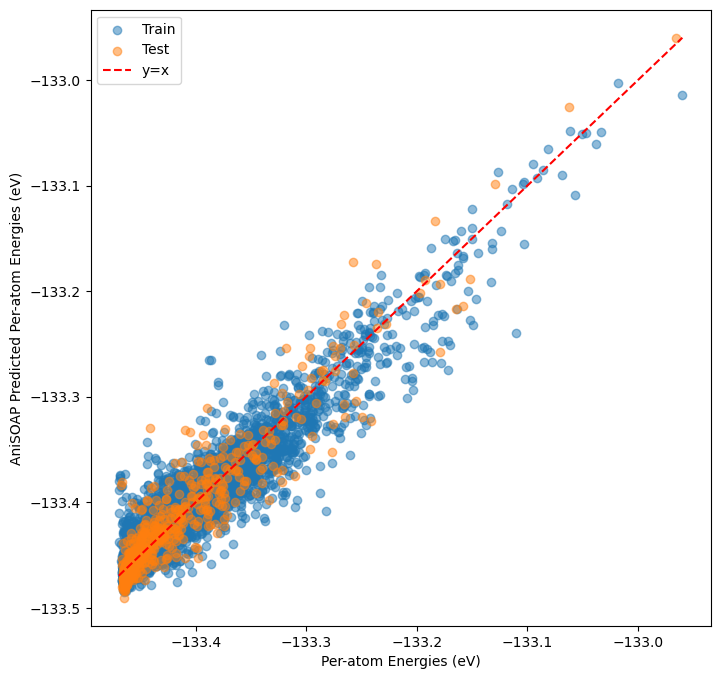

In [9]:
plt.figure(figsize=(8, 8))
plt.scatter(
    y_train_scaler.inverse_transform(y_train),
    y_train_scaler.inverse_transform(lr.predict(x_train).reshape(-1, 1)),
    alpha=0.5,
)

plt.scatter(
    y_test_scaler.inverse_transform(y_test),
    y_test_scaler.inverse_transform(lr.predict(x_test).reshape(-1, 1)),
    alpha=0.5,
)

plt.plot(
    [np.min(energies), np.max(energies)], [np.min(energies), np.max(energies)], "r--"
)
plt.xlabel("Per-atom Energies (eV)")
plt.ylabel("AniSOAP Predicted Per-atom Energies (eV)")
plt.legend(["Train", "Test", "y=x"])

print(f"Train R^2: {lr.score(x_train, y_train):.3f}")
print(f"Test R^2: {lr.score(x_test, y_test):.3f}")